In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from corner import hist2d

import util as UT
import catalog as Cat
import evolver as Evo
import observables as Obvs
import test_evolver as testEvo

In [2]:
theta = Evo.defaultTheta('random_step_abias')
for key in theta.keys(): 
    print key, theta[key]

gv {'slope': 1.03, 'fidmass': 10.5, 'offset': -0.02}
fq {'name': 'cosmos_tinker'}
sfms {'mslope': 0.53, 'name': 'linear', 'zslope': 1.05}
fpq {'slope': -2.079703, 'fidmass': 10.5, 'offset': 1.6153725}
sfh {'sigma_tot': 0.3, 'dt_min': 1.0, 'sigma_corr': 0.2, 'name': 'random_step_abias', 'dt_max': 1.0}
mass {'f_retain': 0.6, 't_step': 0.05, 'solver': 'euler'}


In [3]:
sig_smhm = 0.2
nsnap0=15

In [4]:
def EvoWrap(tt):
    # random step with ASSEMBLY BIAS set to max
    #theta['sfh'] = {'name': 'random_step_abias', 'sigma_tot': 0.3, 'sigma_corr': 0.29, 'dt_min': 0.5, 'dt_max': 0.5}
    sh = Cat.PureCentralHistory(sigma_smhm=sig_smhm, nsnap_ancestor=nsnap0)
    sc = sh.Read()

    eev = Evo.Evolver(sc, tt, nsnap0=nsnap0)
    eev.Initiate()

    eev.Evolve()
    return eev.SH_catalog

In [5]:
def dMhalo_dlogSFR(scat, nsnap): 
    isSF = np.where((scat['gclass'] == 'star-forming') & (scat['nsnap_start'] >= nsnap))[0]
    # main sequence logSFR at ealrier snapshot
    logsfr_ms = Obvs.SSFR_SFMS(scat['snapshot'+str(nsnap)+'_m.star'][isSF], UT.z_nsnap(nsnap), 
                            theta_SFMS=theta['sfms']) + scat['snapshot'+str(nsnap)+'_m.star'][isSF]
    dlogsfr = scat['snapshot'+str(nsnap)+'_sfr'][isSF] - logsfr_ms
    # delta log(Mhalo)
    dlogMhalo = scat['snapshot'+str(nsnap-1)+'_halo.m'][isSF] - scat['snapshot'+str(nsnap)+'_halo.m'][isSF]
    hist2d(dlogMhalo, 0.3*np.random.randn(len(isSF)), range=[[-0.75, 0.75], [-1.,1.]], smooth=True, plot_contours=True, 
           levels=[0.68, 0.95], plot_datapoints=False, fill_contours=True, color='black')
    
    hist2d(dlogMhalo, dlogsfr, range=[[-0.75, 0.75], [-1.,1.]], smooth=True, plot_contours=True, 
           levels=[0.68, 0.95], plot_datapoints=False, fill_contours=True, color='blue')#, alpha=0.1)
    plt.text(0.5, 0.5, str(round(np.std(dlogsfr),4)))
    plt.show()
    plt.close()
    return None

### If there's no assembly bias then it should be the same as random steps
First SFH = `random step`, which has no assembly bias by construction

assignSFRs takes  1.15766906738


evolver.py:315: RuntimeWarning: invalid value encountered in divide
  qf.model(mf[0], z_i, lit=theta_fq['name']) * dmf_dt[1] / mf[1])
evolver.py:327: RuntimeWarning: invalid value encountered in less
  quenches = np.where(rand_Pq < Pq_Msham)  # these SFing galaxies quench
evolver.py:320: RuntimeWarning: divide by zero encountered in divide
  Pq_M_fid_interp(mm) / (1. - qf.model(mm, z_i, lit=theta_fq['name']))
evolver.py:315: RuntimeWarning: divide by zero encountered in divide
  qf.model(mf[0], z_i, lit=theta_fq['name']) * dmf_dt[1] / mf[1])


72.0785369873


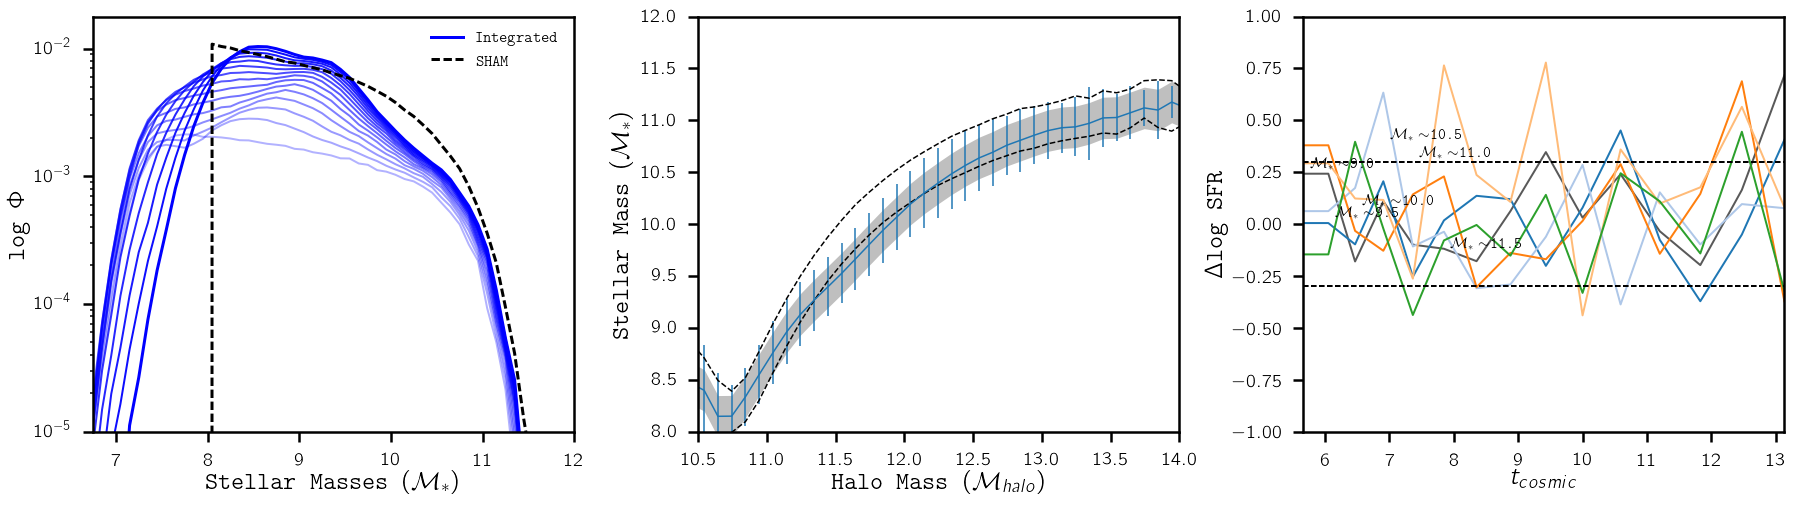

In [6]:
# random step (NO ASSEMBLY BIAS)
t_NOabias = theta.copy()
t_NOabias['sfh'] = {'name': 'random_step', 'dt_min': 0.5, 'dt_max': 0.5, 'sigma': 0.3}

SHcat_NOabias = EvoWrap(t_NOabias)
testEvo.EvolverQAplots(SHcat_NOabias, t_NOabias)
plt.show()

Check for assembly bias by comparing $\Delta {\rm log}\, M_{halo}$ to $\Delta {\rm log\, SFR}$

Note that 
$$ \Delta {\rm log}\, M_{halo} = {\rm log}\, M_{halo}(t_{n}) - {\rm log}\, M_{halo}(t_{n+1})$$
where $n$ is snapshot. So $n+1$ is an earlier snapshot than $n$. Meanwhile
$$ \Delta {\rm log\, SFR} = {\rm log\, SFR}(t_{n+1}) - \overline{{\rm log\, SFR}(t_{n+1})}$$

In [ ]:
for isnap in range(3, 14): 
    dMhalo_dlogSFR(SHcat_NOabias, isnap)

`random_step_abias` with $\sigma_{corr} = 0$

Nothing should change from above based on how it's coded up!

In [ ]:
# random step with ASSEMBLY BIAS set to 0 
theta['sfh'] = {'name': 'random_step_abias', 'sigma_tot': 0.3, 'sigma_corr': 0.0, 'dt_min': 0.5, 'dt_max': 0.5}
subhist = Cat.PureCentralHistory(sigma_smhm=sig_smhm, nsnap_ancestor=nsnap0)
subcat = subhist.Read()

eev = Evo.Evolver(subcat, theta, nsnap0=nsnap0)
eev.Initiate()

eev.Evolve()
subcat_abias0 = eev.SH_catalog

testEvo.EvolverQAplots(subcat_abias0, theta)
plt.show()

In [ ]:
for isnap in range(3, 14): 
    dMhalo_dlogSFR(subcat_abias0, isnap)

looks practically identical, so at least that works...

### Now we crank up the assembly bias

In [ ]:
# random step with ASSEMBLY BIAS set to max
theta['sfh'] = {'name': 'random_step_abias', 'sigma_tot': 0.3, 'sigma_corr': 0.1, 'dt_min': 0.5, 'dt_max': 0.5}
subhist = Cat.PureCentralHistory(sigma_smhm=sig_smhm, nsnap_ancestor=nsnap0)
subcat = subhist.Read()

eev = Evo.Evolver(subcat, theta, nsnap0=nsnap0)
eev.Initiate()

eev.Evolve()
subcat_abias1 = eev.SH_catalog

testEvo.EvolverQAplots(subcat_abias1, theta)
plt.show()

In [ ]:
for isnap in range(3, 14): 
    dMhalo_dlogSFR(subcat_abias1, isnap)

In [ ]:
# random step with ASSEMBLY BIAS set to max
theta['sfh'] = {'name': 'random_step_abias', 'sigma_tot': 0.3, 'sigma_corr': 0.29, 'dt_min': 0.5, 'dt_max': 0.5}
subhist = Cat.PureCentralHistory(sigma_smhm=sig_smhm, nsnap_ancestor=nsnap0)
subcat = subhist.Read()

eev = Evo.Evolver(subcat, theta, nsnap0=nsnap0)
eev.Initiate()

eev.Evolve()
subcat_abias2 = eev.SH_catalog

testEvo.EvolverQAplots(subcat_abias2, theta)
plt.show()

In [ ]:
for isnap in range(3, 14): 
    dMhalo_dlogSFR(subcat_abias2, isnap)

### Lets check if assembly bias is being induced properly

In [ ]:
# lets change around sigma_corr (the correlation between dMhalo and dlogSFR)
for sig in [0., 0.1]:#, 0.2, 0.3]: 
    theta['sfh']['sigma_corr'] = sig
    
    subhist = Cat.PureCentralHistory(sigma_smhm=sig_smhm, nsnap_ancestor=nsnap0)
    subcat = subhist.Read()
    
    eev = Evo.Evolver(subcat, theta, nsnap0=nsnap0)
    eev.Initiate()
    
    eev.Evolve()
    subcat = eev.SH_catalog
    
    testEvo.EvolverQAplots(subcat, theta)
plt.show()

In [ ]:
# random step with ASSEMBLY BIAS set to 0 
theta['sfh'] = {'name': 'random_step_abias', 'sigma_tot': 0.3, 'sigma_corr': 0.0, 'dt_min': 0.5, 'dt_max': 0.5}

subhist = Cat.PureCentralHistory(sigma_smhm=sig_smhm, nsnap_ancestor=nsnap0)
subcat = subhist.Read()

eev = Evo.Evolver(subcat, theta, nsnap0=nsnap0)
eev.Initiate()

eev.Evolve()
subcat = eev.SH_catalog

In [ ]:
isSF = np.where((subcat['gclass'] == 'star-forming') & (subcat['nsnap_start'] >= 11))[0]
plt.scatter(subcat['snapshot10_halo.m'][isSF] - subcat['snapshot11_halo.m'][isSF], subcat['snapshot11_sfr'][isSF])
sfrs = subcat['snapshot11_sfr'][isSF]
print sfrs[np.where(sfrs < -10)]
plt.ylim([-10., 10.])
plt.xlim([-1., 1.])
plt.show()

In [ ]:
print isSF[np.where(sfrs < -10)[0][1]]

In [ ]:
print subcat['nsnap_start'][64]
for i in range(2, 14): 
    print i, subcat['snapshot'+str(i)+'_m.star'][64], subcat['snapshot'+str(i)+'_sfr'][64], subcat['snapshot'+str(i)+'_halo.m'][64], subcat['snapshot'+str(i)+'_m.sham'][64]

In [ ]:
for i in range(2, 14): 
    print subcat['snapshot'+str(i)+'_sfr'][np.where(subcat['nsnap_start'] == i)]

In [ ]:
k